# DYE-Release の Post-Prossecing script

In [1]:
import netCDF4
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from matplotlib import dates as mdates
from pyproj import Proj
from mod_util import in_rect
from matplotlib.animation import FuncAnimation
import datetime
%matplotlib notebook

In [2]:
import matplotlib.colors as mcolors
tab_colors = mcolors.TABLEAU_COLORS
print(tab_colors)
tab_keys = list(tab_colors.keys())
css_colors = mcolors.BASE_COLORS
uni_colors=["#FF4B00","#005AFF","#03AF7A","#40C4FF","#F6AA00","#FFF100","#990099"]
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.get_cmap("tab20").colors)

{'tab:blue': '#1f77b4', 'tab:orange': '#ff7f0e', 'tab:green': '#2ca02c', 'tab:red': '#d62728', 'tab:purple': '#9467bd', 'tab:brown': '#8c564b', 'tab:pink': '#e377c2', 'tab:gray': '#7f7f7f', 'tab:olive': '#bcbd22', 'tab:cyan': '#17becf'}


## 河川の栄養塩濃度推定

In [3]:
#河川の栄養塩量を推定
df = pd.read_csv('./data/river_nutrient.csv')
df.head()

,Unnamed: 0,水域名,河川名,地点名,採取年月日,採取時刻,流量,水温,アンモニア性窒素,亜硝酸性窒素,硝酸性窒素,燐酸性燐,date
0,0,江戸川,江戸川,新葛飾橋,2020/11/11,16:00,28.95,12.7,0.02,0.015,2.60,0.059,2020-11-11 16:00:00
1,1,江戸川,江戸川,新葛飾橋,2021/01/06,11:10,32.23,5.2,0.13,0.027,2.00,0.060,2021-01-06 11:00:00
2,2,江戸川,江戸川,新葛飾橋,2021/03/03,08:30,36.38,9.7,0.16,0.061,2.30,0.081,2021-03-03 08:00:00
3,3,江戸川,旧江戸川,今井橋,2020/12/03,08:40,NaN,11.8,0.12,0.040,3.52,0.080,2020-12-03 08:00:00
4,4,江戸川,旧江戸川,今井橋,2021/02/04,10:15,NaN,11.1,0.16,0.070,5.10,0.157,2021-02-04 10:00:00


In [ ]:
river_list = ['隅田川','江戸川','中川','荒川','多摩川']
locs = ['両国橋','浦安橋','葛西小橋','葛西橋','大師橋']
DIN,DIP =[],[]
for river,loc in zip(river_list,locs):
    tmp = df[df['水域名'] == river]
    tmp = tmp[tmp['地点名'] == loc]
    tmp = tmp.reset_index(drop=True)
    print(tmp)
    DIN.append((tmp['アンモニア性窒素'][0]+tmp['亜硝酸性窒素'][0]+tmp['硝酸性窒素'][0] \
              + tmp['アンモニア性窒素'][1]+tmp['亜硝酸性窒素'][1]+tmp['硝酸性窒素'][1])/2)
    DIP.append((tmp['燐酸性燐'][0]+tmp['燐酸性燐'][1]/2))
print(DIN,DIP)


## netCDFのインポート

In [7]:
#ncfile = "/work/gy29/y29007/Github/fvcom442/work/Tokyo/rundye/dye*_0001.nc"
#paths = sorted(glob(ncfile))
paths = [f"/work/gy29/y29007/Github/fvcom442/work/Tokyo/rundye/dyesewer{str(i)}_0001.nc" for i in range(0,12)]
paths = ["/work/gy29/y29007/Github/fvcom442/work/Tokyo/rundye/dye_normal_0001.nc"]
paths

['/work/gy29/y29007/Github/fvcom442/work/Tokyo/rundye/dye_normal_0001.nc']

In [3]:
def read_map_and_dye(path):
    nc = netCDF4.Dataset(path,'r')
    #read_dye
    #print(nc.variables['DYE'])
    dye = nc.variables['DYE'][:,:,:].data #time,siglay,node
    art1 = nc.variables['art1'][:].data # node control area の面積
    siglay = nc.variables['siglay'][:,100].data
    
    #read_map
    h = nc.variables['h'][:].data
    x = nc.variables['x'][:].data
    y = nc.variables['y'][:].data
    e2u_conv=Proj(proj='utm', zone=54, ellps='WGS84') #Convert UTM2EQA
    rslt = [e2u_conv(lon,lat,inverse=True) for lon,lat in zip(x,y)]
    lon = [rslt[i][0] for i in range(len(rslt))]
    lat = [rslt[i][1] for i in range(len(rslt))]
    
    triangles = nc.variables['nv'][:].T-1
    
    return dye,lon,lat,triangles,h,art1,siglay


In [4]:
def concat_dye(ave_c_list,numbers,plottime):
    res=np.zeros(plottime)
    for j in range(plottime):
        s = 0
        for i in numbers:
            s += ave_c_list[i][j]
        res[j]=s
    return res
    

## ポリゴンの定義とノード番号の抽出
### 領域全体での時系列コンターマップと割合を作成
ポリゴンは四角形，ポリゴンの点は必ず反時計回りに取ること

In [33]:
rect_futtsu = [[139.78523, 35.31256],[139.81572, 35.32],[139.80904, 35.34579], \
               [139.77752, 35.33203]]
rect_San1 = [[139.93942,35.64125],[139.96,35.64846],[139.94588,35.66822],[139.92355,35.66126]]
rect_San2 = [[139.96942,35.65025],[139.9819,35.65146],[139.97288,35.66922],[139.95355,35.67126]]
rect_Kisarazu = [[139,.85992,35.3739],[139.94,35.39],[139.93134,35.44],[139.878,35.437]]

In [47]:
##read netCDF
#river_list = ['隅田川','江戸川','中川','荒川','多摩川']
#[4.9695, 3.58, 2.3905000000000003, 4.629, 3.7104999999999997]
river_list = ["Arakawa","Sumidagawa","edogawa","Tamagawa","Tsurumigawa","Mamagawa","Ebigawa","Yorogawa",\
    "Obitsugawa","Koitogawa","Muratagawa","Hanamigawa","Shibaura","Sunamachi","Ariake","Morigasaki","Kasai","Open Boundary"]
DIN_INFLOW=[330.64  ,354.96 , 255.71 , 265.00 , 535.00 , 435.71, 490.00 ,59.29, 80.00, 82.86 ,162.14, 0 ,1935, 714 ,478, 1442 ,678,4 ]
nc = netCDF4.Dataset("./exp31/exp0_0001.nc",'r')
dye_base = nc.variables['DYE'][:,:,:]
dye_base[0,0,:5]
plottime=dye_base.shape[2]//24
plottime=62
plottime

62

In [48]:
dye_base.shape

(2233, 30, 3210)

## 富津 

In [94]:
ave_c_list = []
nc = netCDF4.Dataset("./exp31/exp0_0001.nc",'r')
dye_base = nc.variables['DYE'][:,:,:]
#paths = [f"/work/gy29/y29007/Github/fvcom442/work/Tokyo/rundye/exp/exp{str(i)}_0001.nc" for i in range(1,19)]
paths = [f"./exp31/exp{str(i)}_0001.nc" for i in range(1,19)]
for river,path,ratio in zip(river_list,paths,DIN_INFLOW):
    dye,lon,lat,triangles,h,art1,siglay = read_map_and_dye(path)
    ntime,nsiglay,nnode=dye.shape
    #dye =   dye - dye_base
    dye =   dye_base -dye
    ave_c = ave_concentration(path,dye,rect_futtsu,1)
    ave_c_list.append(ave_c)
    
    print(f"{river}, done!")


Arakawa, done!
Sumidagawa, done!
edogawa, done!
Tamagawa, done!
Tsurumigawa, done!
Mamagawa, done!
Ebigawa, done!
Yorogawa, done!
Obitsugawa, done!
Koitogawa, done!
Muratagawa, done!
Hanamigawa, done!
Shibaura, done!
Sunamachi, done!
Ariake, done!
Morigasaki, done!
Kasai, done!
Open Boundary, done!


In [95]:
ave_c_list2 = []
for i in range(len(paths)):
    ave_c_list2.append([np.average(ave_c_list[i][24*j:24*j+23]) for j in range(plottime)])

In [96]:
ave_c_list2[-1]

[-0.03297896086044935,
 0.02141009922436557,
 -0.005226775858102927,
 0.26118959692583177,
 0.2986562274965182,
 0.3399106151640203,
 0.23989620800578723,
 3.501088692854803,
 2.350833540163691,
 2.5579188556926304,
 2.943493284927884,
 2.5183046998040792,
 2.6680649685196682,
 3.2005511583603568,
 3.9730862732644265,
 3.115300022650971,
 4.907513342872111,
 6.706231594580425,
 6.233300615380117,
 8.248018125440366,
 7.195566274804429,
 7.010048553576402,
 6.852251905359345,
 5.84156353436897,
 7.108945192169921,
 7.114191955357643,
 7.560984592236419,
 7.832904725143887,
 7.584935798634879,
 7.264284030560216,
 6.823475105976547,
 6.7264794027187165,
 6.77879604999788,
 7.031435015605062,
 7.3892726976659215,
 8.537772740312276,
 9.467028876546523,
 10.51092366309984,
 12.166165828434107,
 10.498425414292425,
 10.70557319320284,
 10.644556950504525,
 10.247382855235069,
 10.152997498183757,
 10.240738349046746,
 10.608243437049051,
 10.004193371666968,
 11.541279518651153,
 12.1326108

In [97]:
#path = "/work/gy29/y29007/Github/fvcom442/work/Tokyo/rundye/exp/exp0_0001.nc"
path = "./exp31/exp0_0001.nc"
c_all = ave_concentration(path,dye_base,rect_futtsu,ratio)
c_all = [np.average(c_all[24*j:24*j+23]) for j in range(plottime)]

In [98]:
river_total=concat_dye(ave_c_list2,[0,1,2,3,4,5,6,7,8,9,10,11],plottime)
small_total=concat_dye(ave_c_list2,[5,6,7,8,10,11],plottime)
sewer_total=concat_dye(ave_c_list2,[12,13,14,15,16,17],plottime)
#print(river_total,small_total,sewer_total)

<IPython.core.display.Javascript object>


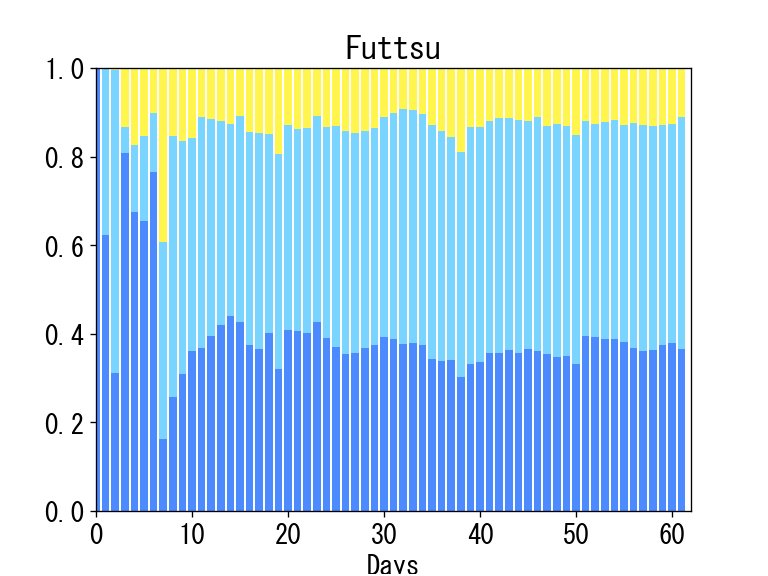

In [99]:
#plot spec
plt.rcParams['font.family'] = 'MS Gothic'
plt.rcParams['font.size'] = 16
total = river_total+sewer_total+ave_c_list2[-1]
r = river_total/total
sewer = sewer_total/total
obc = ave_c_list2[-1]/total

#print(r[:],small[:],sewer[:])
labels=["River","Sewer","Open Boundary"]
date = [i for i in range(plottime)]#[::10]
fig,ax = plt.subplots(facecolor="white")

#ax.stackplot(date,[r,sewer,obc])
ax.bar(date,r,label="River",color=uni_colors[1],alpha=0.7)
ax.bar(date,sewer,bottom=r,label="Sewer",color=uni_colors[3],alpha=0.7)
ax.bar(date,obc,bottom=r+sewer,label="Open Boundary",color=uni_colors[5],alpha=0.7)
#ax.bar(obc)
ax.set_title("Futtsu");ax.set_xlabel('Days')
ax.set_ylim(0,1);ax.set_xlim(0,plottime)
#ax.legend()
fig.savefig("exp3_wvar_spec_futtsu.png",dpi=600,bbox_inches="tight")
plt.show()

<IPython.core.display.Javascript object>


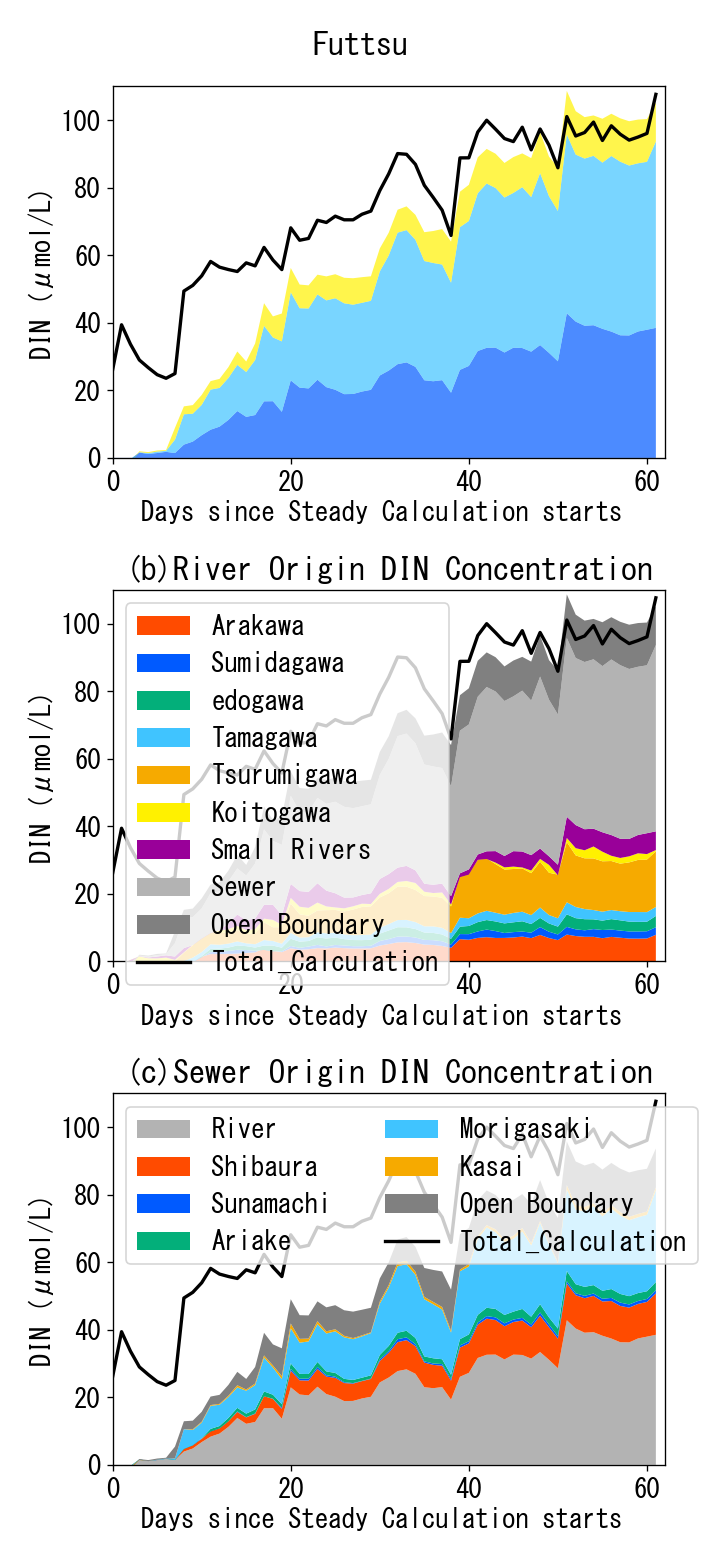

In [101]:
fig,ax = plt.subplots(3,1,facecolor="white",figsize=(6,13))
#date = [datetime.datetime(2021,1,31,0,0)+ datetime.timedelta(days=i) for i in range(61)]
date = [i for i in range(plottime)]
fig.suptitle('Futtsu')
###ax1:total###################
ax1=ax[0]
labels=["River","Sewer","Open Boundary"]
ax1.stackplot(date,[river_total,sewer_total,ave_c_list2[-1]]
                   ,labels=labels,colors=[uni_colors[1],uni_colors[3],uni_colors[5]],alpha=0.7)

ax1.plot(date,c_all,label="Total_Calculation",color='black',lw=2)

#ax1.legend(loc='upper left');ax1.set_title('(a)Total DIN Concentration')
ax1.set_xlabel('Days since Steady Calculation starts ');
ax1.set_ylabel('DIN (μmol/L)')
###ax2:rier###################
ax2=ax[1]
labels=[river_list[0],river_list[1],river_list[2],river_list[3],river_list[4],river_list[9],"Small Rivers","Sewer","Open Boundary"]
ax2.stackplot(date,[ave_c_list2[0],ave_c_list2[1],ave_c_list2[2],ave_c_list2[3],ave_c_list2[4],ave_c_list2[9],small_total,sewer_total,ave_c_list2[-1]]
                   ,labels=labels,colors=[uni_colors[0],uni_colors[1],uni_colors[2],uni_colors[3],uni_colors[4],uni_colors[5],uni_colors[6]
                                          , "0.7", "0.5"])

ax2.plot(date,c_all,label="Total_Calculation",color='black',lw=2)

ax2.legend(loc='upper left');ax2.set_xlabel('Days since Steady Calculation starts ');
ax2.set_ylabel('DIN (μmol/L)');
ax2.set_title("(b)River Origin DIN Concentration")
###ax3:sewer################
ax3=ax[2]
labels=["River",river_list[12],river_list[13],river_list[14],river_list[15],river_list[16],"Open Boundary"]
ax3.stackplot(date,[river_total,ave_c_list2[12],ave_c_list2[13],ave_c_list2[14],ave_c_list2[15],ave_c_list2[16],ave_c_list2[-1]]
                   ,labels=labels,colors=["0.7",uni_colors[0],uni_colors[1],uni_colors[2],uni_colors[3],uni_colors[4]
                                          ,  "0.5"])

ax3.plot(date,c_all,label="Total_Calculation",color='black',lw=2)

ax3.legend(loc='upper left',ncols=2);ax3.set_xlabel('Days since Steady Calculation starts ');ax3.set_ylabel('DIN (μmol/L)')
ax3.set_title("(c)Sewer Origin DIN Concentration")
for axs in ax:
    axs.set_xlim(0,plottime)
    axs.set_ylim(0,110)
plt.tight_layout()
fig.savefig('./png/exp3_wvar_DIN_concentration_Futtsu.png',dpi=300,bbox_inches='tight')

## 木更津

In [77]:
ave_c_listk = []
paths = [f"./exp31/exp{str(i)}_0001.nc" for i in range(1,19)]
nc = netCDF4.Dataset("./exp31/exp0_0001.nc",'r')
dye_base = nc.variables['DYE'][:,:,:]
#paths = [f"/work/gy29/y29007/Github/fvcom442/work/Tokyo/rundye/exp/exp{str(i)}_0001.nc" for i in range(1,19)]
for river,path,ratio in zip(river_list,paths,DIN_INFLOW):
    dye,lon,lat,triangles,h,art1,siglay = read_map_and_dye(path)
    ntime,nsiglay,nnode=dye.shape
    #dye =  dye - dye_base 
    dye =  dye_base -dye
    ave_c = ave_concentration(path,dye,rect_Kisarazu,ratio)
    ave_c_listk.append(ave_c)
    
    print(f"{river}, done!")


Arakawa, done!
Sumidagawa, done!
edogawa, done!
Tamagawa, done!
Tsurumigawa, done!
Mamagawa, done!
Ebigawa, done!
Yorogawa, done!
Obitsugawa, done!
Koitogawa, done!
Muratagawa, done!
Hanamigawa, done!
Shibaura, done!
Sunamachi, done!
Ariake, done!
Morigasaki, done!
Kasai, done!
Open Boundary, done!


In [78]:
ave_c_list2k = []
for i in range(18):
    ave_c_list2k.append([np.average(ave_c_listk[i][24*j:24*j+23]) for j in range(plottime)])

In [79]:
path = "./exp31/exp0_0001.nc"
c_all = ave_concentration(path,dye_base,rect_Kisarazu,ratio)
c_all = [np.average(c_all[24*j:24*j+23]) for j in range(plottime)]

In [102]:
river_total=concat_dye(ave_c_list2k,[0,1,2,3,4,5,6,7,8,9,10,11,12],plottime)
small_total=concat_dye(ave_c_list2k,[5,6,7,9,10,11,12],plottime)
sewer_total=concat_dye(ave_c_list2k,[12,13,14,15,16,17],plottime)

<IPython.core.display.Javascript object>


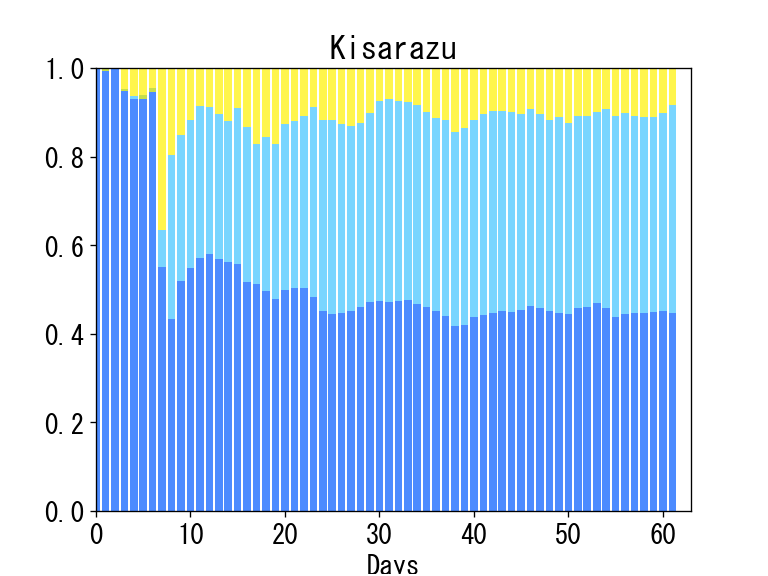

In [105]:
#plot spec
plt.rcParams['font.family'] = 'MS Gothic'
plt.rcParams['font.size'] = 16
total = river_total+sewer_total+ave_c_list2[-1]
r = river_total/total
sewer = sewer_total/total
obc = ave_c_list2[-1]/total

#print(r[:],small[:],sewer[:])
labels=["River","Sewer","Open Boundary"]
date = [i for i in range(plottime)]#[::10]
fig,ax = plt.subplots(facecolor="white")

#ax.stackplot(date,[r,sewer,obc])
ax.bar(date,r,label="River",color=uni_colors[1],alpha=0.7)
ax.bar(date,sewer,bottom=r,label="Sewer",color=uni_colors[3],alpha=0.7)
ax.bar(date,obc,bottom=r+sewer,label="Open Boundary",color=uni_colors[5],alpha=0.7)
#ax.bar(obc)
ax.set_title("Kisarazu");ax.set_xlabel('Days')
ax.set_ylim(0,1);ax.set_xlim(0,63)
#ax.legend()
fig.savefig("exp3_wvar_spec_Kisarazu.png",dpi=600,bbox_inches="tight")
plt.show()

<IPython.core.display.Javascript object>


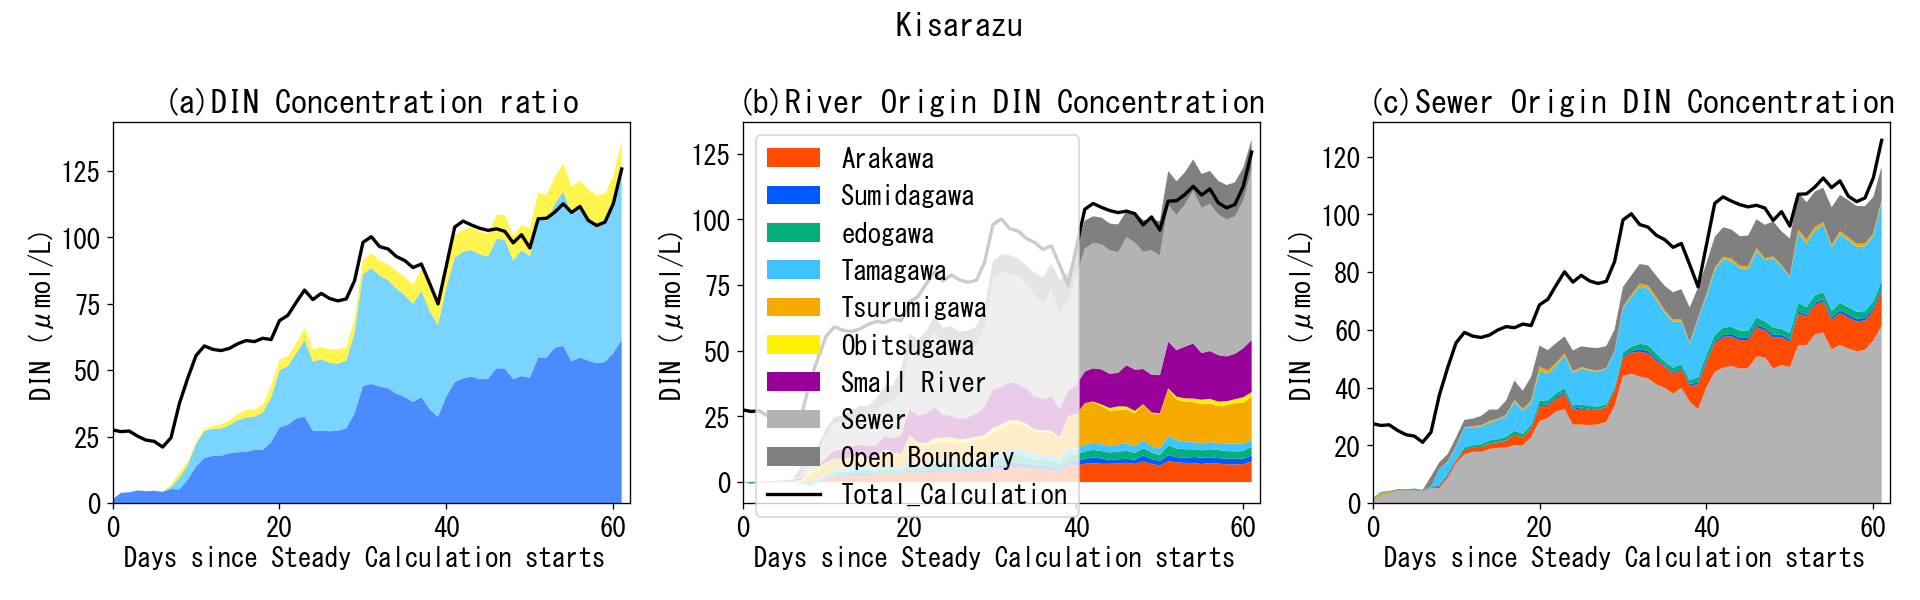

In [92]:

fig,ax = plt.subplots(1,3,facecolor="white",figsize=(16,5))
#date = [datetime.datetime(2021,1,31,0,0)+ datetime.timedelta(days=i) for i in range(61)]
date = [i for i in range(plottime)]
fig.suptitle('Kisarazu')
###ax1:total###################
ax1=ax[0]
labels=["River","Sewer","Open Boundary"]
ax1.stackplot(date,[river_total,sewer_total,ave_c_list2k[-1]]
                   ,labels=labels,colors=[uni_colors[1],uni_colors[3],uni_colors[5]],alpha=0.7)

ax1.plot(date,c_all,label="Total_Calculation",color='black',lw=2)

#ax1.legend(loc='upper left')
ax1.set_title('(a)DIN Concentration ratio')
ax1.set_xlabel('Days since Steady Calculation starts ');
ax1.set_ylabel('DIN (μmol/L)')
###ax2:river###################
ax2=ax[1]
labels=[river_list[0],river_list[1],river_list[2],river_list[3],river_list[4],river_list[8],"Small River","Sewer","Open Boundary"]
ax2.stackplot(date,[ave_c_list2[0],ave_c_list2[1],ave_c_list2[2],ave_c_list2[3],ave_c_list2[4],ave_c_list2[8],small_total,sewer_total,ave_c_list2[-1]]
                   ,labels=labels,colors=[uni_colors[0],uni_colors[1],uni_colors[2],uni_colors[3],uni_colors[4],uni_colors[5],uni_colors[6]
                                          , "0.7", "0.5"])

ax2.plot(date,c_all,label="Total_Calculation",color='black',lw=2)

ax2.legend(loc='upper left');ax2.set_xlabel('Days since Steady Calculation starts ');
ax2.set_ylabel('DIN (μmol/L)');
ax2.set_title("(b)River Origin DIN Concentration")
###ax3:sewer################
ax3=ax[2]
labels=["River",river_list[12],river_list[13],river_list[14],river_list[15],river_list[16],"Open Boundary"]
ax3.stackplot(date,[river_total,ave_c_list2[12],ave_c_list2[13],ave_c_list2[14],ave_c_list2[15],ave_c_list2[16],ave_c_list2[-1]]
                   ,labels=labels,colors=["0.7",uni_colors[0],uni_colors[1],uni_colors[2],uni_colors[3],uni_colors[4]
                                          ,  "0.5"])

ax3.plot(date,c_all,label="Total_Calculation",color='black',lw=2)

#ax3.legend(loc='upper left');
ax3.set_xlabel('Days since Steady Calculation starts ');ax3.set_ylabel('DIN (μmol/L)')
ax3.set_title("(c)Sewer Origin DIN Concentration")
for axs in ax:
    axs.set_xlim(0,plottime)
    #axs.set_ylim(0,120)
plt.tight_layout()
fig.savefig('./png/exp3_wvar_DIN_concentration_Kisarazu.png',dpi=300,bbox_inches='tight')


## 三番瀬

In [108]:
plottime=62
ave_c_lists = []
ncs = netCDF4.Dataset("./exp31/exp0_0001.nc",'r')
dye_base = ncs.variables['DYE'][:,:,:]
paths = [f"./exp31/exp{str(i)}_0001.nc" for i in range(1,19)]
#paths = [f"/work/gy29/y29007/Github/fvcom442/work/Tokyo/rundye/exp/exp{str(i)}_0001.nc" for i in range(1,19)]
for river,path,ratio in zip(river_list,paths,DIN_INFLOW):
    dye,lon,lat,triangles,h,art1,siglay = read_map_and_dye(path)
    ntime,nsiglay,nnode=dye.shape
    dye = dye_base - dye
    #dye = dye-dye_base 
    ave_c = ave_concentration(path,dye,rect_San1,ratio,rect2_flag=True,rect2=rect_San2)
    ave_c_lists.append(ave_c)
    
    print(f"{river}, done!")

    


Arakawa, done!
Sumidagawa, done!
edogawa, done!
Tamagawa, done!
Tsurumigawa, done!
Mamagawa, done!
Ebigawa, done!
Yorogawa, done!
Obitsugawa, done!
Koitogawa, done!
Muratagawa, done!
Hanamigawa, done!
Shibaura, done!
Sunamachi, done!
Ariake, done!
Morigasaki, done!
Kasai, done!
Open Boundary, done!


In [109]:
ave_c_list2s = []
for i in range(len(paths)):
    ave_c_list2s.append([np.average(ave_c_lists[i][24*j:24*j+23]) for j in range(plottime)])

In [110]:
path = "./exp31/exp0_0001.nc"
c_alls = ave_concentration(path,dye_base,rect_San1,ratio,rect2_flag=True,rect2=rect_San2)
c_alls = [np.average(c_alls[24*j:24*j+23]) for j in range(plottime)]

In [111]:
river_totals=concat_dye(ave_c_list2s,[0,1,2,3,4,5,6,7,8,9,10,11,12],plottime)
small_totals=concat_dye(ave_c_list2s,[8,9,10,11,12],plottime)
major_totals=concat_dye(ave_c_list2s,[0,1,2,3,4],plottime)
sewer_totals=concat_dye(ave_c_list2s,[12,13,14,15,16,17],plottime)

<IPython.core.display.Javascript object>


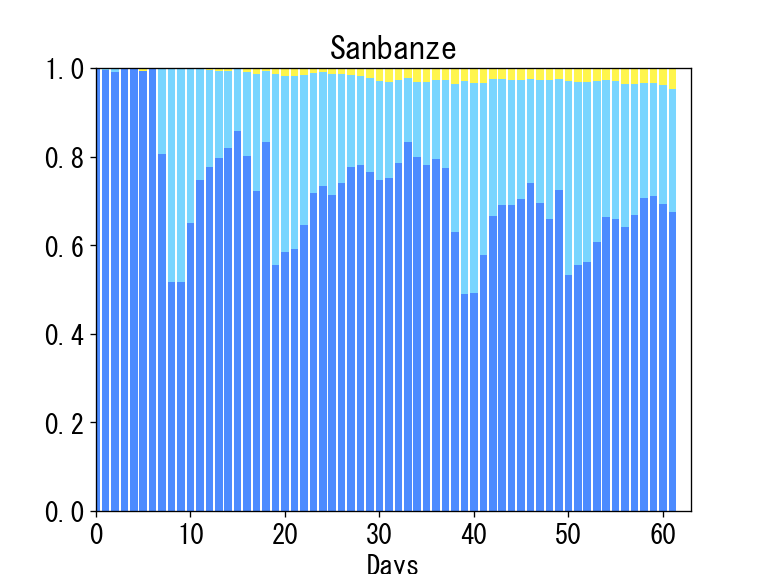

In [112]:
#plot spec
plt.rcParams['font.family'] = 'MS Gothic'
plt.rcParams['font.size'] = 16
total = river_totals+sewer_totals+ave_c_list2s[-1]
r = river_totals/total
sewer = sewer_totals/total
obc = ave_c_list2s[-1]/total

#print(r[:],small[:],sewer[:])
labels=["River","Sewer","Open Boundary"]
date = [i for i in range(plottime)]#[::10]
fig,ax = plt.subplots(facecolor="white")

#ax.stackplot(date,[r,sewer,obc])
ax.bar(date,r,label="River",color=uni_colors[1],alpha=0.7)
ax.bar(date,sewer,bottom=r,label="Sewer",color=uni_colors[3],alpha=0.7)
ax.bar(date,obc,bottom=r+sewer,label="Open Boundary",color=uni_colors[5],alpha=0.7)
#ax.bar(obc)
ax.set_title("Sanbanze");ax.set_xlabel('Days')
ax.set_ylim(0,1);ax.set_xlim(0,63)
#ax.legend()
fig.savefig("exp3_wvar_spec_Sanbanze.png",dpi=600,bbox_inches="tight")
plt.show()

<IPython.core.display.Javascript object>


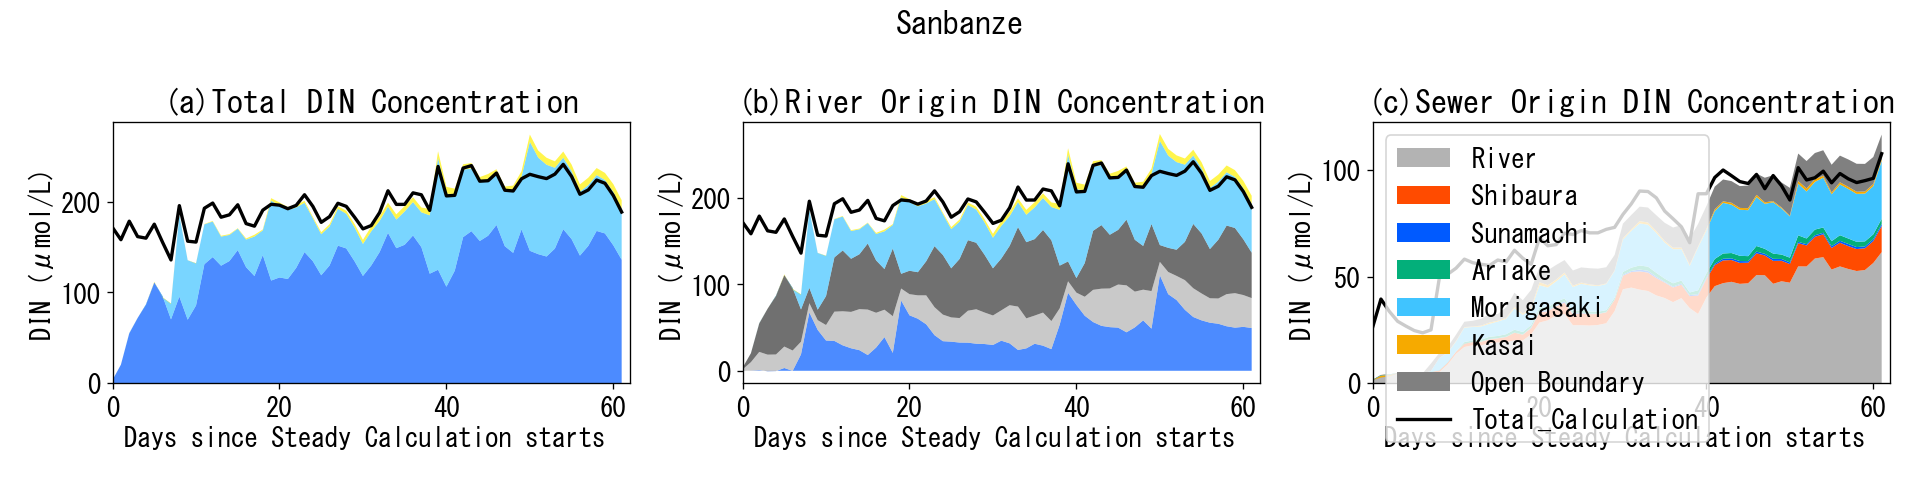

In [118]:
fig,ax = plt.subplots(1,3,facecolor="white",figsize=(16,4))
#date = [datetime.datetime(2021,1,31,0,0)+ datetime.timedelta(days=i) for i in range(61)]
date = [i for i in range(plottime)]
fig.suptitle('Sanbanze')
###ax1:total###################
ax1=ax[0]
labels=["River","Sewer","Open Boundary"]
ax1.stackplot(date,[river_totals,sewer_totals,ave_c_list2s[-1]]
                   ,labels=labels,colors=[uni_colors[1],uni_colors[3],uni_colors[5]],alpha=0.7)

ax1.plot(date,c_alls,label="Total_Calculation",color='black',lw=2)

#ax1.legend(loc='upper left')
ax1.set_title('(a)Total DIN Concentration')
ax1.set_xlabel('Days since Steady Calculation starts ');
ax1.set_ylabel('DIN (μmol/L)')
###ax2:river###################
ax2=ax[1]
labels=["Rivers", river_list[5],river_list[6],"Sewer","Open Boundary"]
ax2.stackplot(date,[major_totals+small_totals,ave_c_list2s[5],ave_c_list2s[6],sewer_totals,ave_c_list2s[-1]]
                   ,labels=labels,colors=[uni_colors[1],"0.7","0.2",uni_colors[3],uni_colors[5]],alpha=0.7)

ax2.plot(date,c_alls,label="Total_Calculation",color='black',lw=2)

#ax2.legend(loc='upper left')
ax2.set_xlabel('Days since Steady Calculation starts ');
ax2.set_ylabel('DIN (μmol/L)');
ax2.set_title("(b)River Origin DIN Concentration")
###ax3:sewer################
ax3=ax[2]
labels=["River",river_list[12],river_list[13],river_list[14],river_list[15],river_list[16],"Open Boundary"]
ax3.stackplot(date,[river_total,ave_c_list2[12],ave_c_list2[13],ave_c_list2[14],ave_c_list2[15],ave_c_list2[16],ave_c_list2[-1]]
                   ,labels=labels,colors=["0.7",uni_colors[0],uni_colors[1],uni_colors[2],uni_colors[3],uni_colors[4]
                                          ,  "0.5"])

ax3.plot(date,c_all,label="Total_Calculation",color='black',lw=2)

ax3.legend(loc='upper left');ax3.set_xlabel('Days since Steady Calculation starts ');ax3.set_ylabel('DIN (μmol/L)')
ax3.set_title("(c)Sewer Origin DIN Concentration")
for axs in ax:
    axs.set_xlim(0,plottime)
    #axs.set_ylim(0,250)
plt.tight_layout()
fig.savefig('./png/exp3_wvar_DIN_concentration_Sanbanze.png',dpi=300,bbox_inches='tight')

In [38]:
def ave_concentration(path,dye,rect,ratio,rect2_flag=False,rect2=0):
    """
   dyeの全深さ方向での領域平均濃度を求める
   ノリの養殖は浅いところで行われるので表層だけで平均したものを作っても良い．
    """
    dummy,lon,lat,triangles,h,art1,siglay = read_map_and_dye(path) #dyeは引き算になったのでここで読み込まない
    in_node = [in_rect(rect,[lonn,latn]) for lonn,latn in zip(lon,lat)]
    if rect2_flag:
        in_node2=[in_rect(rect2,[lonn,latn]) for lonn,latn in zip(lon,lat)]
    ntime,nsiglay,nnode=dye.shape
    
    #calc average
    volume,c = 0,np.zeros(ntime)
    for i in range(nnode):
        if rect2_flag:
            if in_node2[i]:
                volume += art1[i] * h[i]
                for j in range(nsiglay):
                    c[:] += dye[:,j,i] * art1[i] * (1/30) * h[i]# *ratio
                
        if in_node[i]:
            volume += art1[i] * h[i]
            for j in range(nsiglay):
                c[:] += dye[:,j,i] * art1[i] * (1/30) * h[i]# *ratio
                
    ave_c = np.zeros(ntime)            
    ave_c[:] = c[:]/volume
    
    
    return ave_c
    

In [ ]:
def ave_concentration_only_upper(path,rect,ratio):
    """
   dyeの全深さ方向での領域平均濃度を求める
   ノリの養殖は浅いところで行われるので表層だけで平均したものを作っても良い．
    """
    dye,lon,lat,triangles,h,art1,siglay = read_map_and_dye(path)
    in_node = [in_rect(rect,[lonn,latn]) for lonn,latn in zip(lon,lat)]
    ntime,nsiglay,nnode=dye.shape
    
    #calc average
    volume,c = 0,np.zeros(ntime)
    for i in range(nnode):
        if in_node[i]:
            volume += art1[i] * h[i]
            for j in range(nsiglay):
                c[:] += dye[:,j,i] * art1[i] * (1/30) * h[i] *ratio
                
    ave_c = np.zeros(ntime)            
    ave_c[:] = c[:]/volume
    
    
    return ave_c

## gifの作成

In [16]:

def make_gif(lon,lat,dye,triangles,savename,ratio=1.0):
    #日付のラベル用　手動で合わせる
    date_ary =pd.date_range("2020-01-31 00:00:00", periods=310*24+1, freq="H")

    tstep = 24
    #cmapの上限，下限
    vmin = -5
    vmax= ratio/2

    #描画長さ
    count= len(dye[:,0])//tstep

    fig,axs = plt.subplots(figsize=(8,6))
    axs.set_aspect('equal')
    axs.set_ylabel('Latitude(deg)')
    axs.set_xlabel('Longitude(deg)')

    #initialize
    pcolor = axs.tripcolor(lon,lat,dye[0,:]*ratio,triangles=triangles,vmin=vmin,vmax=vmax,cmap='jet')
    inflow  =str(ratio)
    fig.colorbar(pcolor,label=f"DIN_Concentration(inflow={inflow} μmol/L)")

    #update function
    def update(frame):
        
        axs.set_title(date_ary[frame*tstep]) 
        axs.tripcolor(lon,lat,dye[frame*tstep,:],triangles=triangles,cmap='jet',vmin=vmin,vmax=vmax)


    fig.suptitle(savename)
    anim = FuncAnimation(fig, update,save_count=count-1,interval=200)
    plt.tight_layout()
    anim.save(f'./png/exp12_{savename}_dye.mp4',writer="ffmpeg",dpi=200)

In [ ]:
river_list = ["Arakawa","Sumidagawa","edogawa","Tamagawa","Tsurumigawa","Mamagawa","Ebigawa","Yorogawa",\
    "Obitsugawa","Koitogawa","Muratagawa","Hanamigawa","Shibaura","Sunamachi","Ariake","Morigasaki","Kasai","Open Boundary"]
DIN_INFLOW=[330.64  ,354.96 , 255.71 , 265.00 , 535.00 , 435.71, 490.00 ,59.29, 80.00, 82.86 ,162.14, 0 ,1935, 714 ,478, 1442 ,678 ]
paths=[f"/work/gy29/y29007/Github/fvcom442/work/Tokyo/rundye/exp12/exp2_{str(i)}_0001.nc" for i in range(1,18)]
#ratio = [7.74,6.11,0.11,18.44,5.44]
i = 0
for river,path,ratio in zip(river_list,paths,DIN_INFLOW):
    dye,lon,lat,triangles,h,art1,siglay = read_map_and_dye(path)
   # dye = dye_base-dye
    dye = dye-dye_base
    make_gif(lon,lat,dye[:,0,:],triangles,river,ratio) #lon,lat,dye,triangles,savename,ratio
    print(f"{river}, done!")
    i +=1

In [11]:
from PyFVCOM.plot import Depth
#from PyFVCOM.grid import unstructured_grid_depths
from PyFVCOM.read import FileReader
import matplotlib.pyplot as plt
import numpy as np
import sys
from pyproj import Proj

No mpl_toolkits.basemap (deprecated) found in this python installation. Disable basemap. (c:\users\ishid\github\pyfvcom-main\PyFVCOM\plot.py:40)


In [8]:
path = [f"./exp11/exp18_0001.nc"]

dye,lon,lat,triangles,h,art1,siglay = read_map_and_dye(path[0])
ntime,nsiglay,nnode=dye.shape


In [9]:
dye = dye_base -dye

In [12]:
fvcom_pyfvcom = FileReader(path[0], variables=['zeta'])

In [129]:


lon_lat1, lon_lat2 = (139.747, 35.0124), (139.7948, 35.252) 
positions = np.array((lon_lat1, lon_lat2)) 
indices, distances = fvcom_pyfvcom.horizontal_transect_nodes(positions)
#p = Proj(proj='utm',zone=54,ellps='WGS84', preserve_units=False)
x1,y1 =p(lon_lat1[0],lon_lat1[1])[0],p(lon_lat1[0],lon_lat1[1])[1]
x2,y2 =p(lon_lat2[0],lon_lat2[1])[0],p(lon_lat2[0],lon_lat2[1])[1]

print(f"start={indices[0]}, end={indices[-1]}")
#補正
p = Proj(proj='utm',zone=54,ellps='WGS84', preserve_units=False)
#x1,y1 =p(lon_lat1[0],lon_lat1[1])[0],p(lon_lat1[0],lon_lat1[1])[1]
#x2,y2 =p(lon_lat2[0],lon_lat2[1])[0],p(lon_lat2[0],lon_lat2[1])[1]
true_dist =((x1-x2)**2 + ((y1-y2)**2)) **0.5
for i in range(len(distances)):
    distances[i] = true_dist*distances[i]/distances[-1]
#indices=[];distances=[]
lon_lat1, lon_lat2 =(139.7948, 35.252)   , (139.7832, 35.3166) ## Estuary example
positions = np.array((lon_lat1, lon_lat2)) 
indices1, distances1 = fvcom_pyfvcom.horizontal_transect_nodes(positions)
x1,y1 =p(lon_lat1[0],lon_lat1[1])[0],p(lon_lat1[0],lon_lat1[1])[1]
x2,y2 =p(lon_lat2[0],lon_lat2[1])[0],p(lon_lat2[0],lon_lat2[1])[1]
true_dist1 =((x1-x2)**2 + ((y1-y2)**2)) **0.5

print(f"start1={indices1[0]}, end1={indices1[-1]}")
for i in range(len(distances1)):
    distances1[i] = (true_dist1*distances1[i]/distances1[-1]) +true_dist

lon_lat1, lon_lat2 =(139.7832, 35.3166) , (140.0736,35.5746) 
x1,y1 =p(lon_lat1[0],lon_lat1[1])[0],p(lon_lat1[0],lon_lat1[1])[1]
x2,y2 =p(lon_lat2[0],lon_lat2[1])[0],p(lon_lat2[0],lon_lat2[1])[1]
true_dist2 =((x1-x2)**2 + ((y1-y2)**2)) **0.5
positions = np.array((lon_lat1, lon_lat2)) 
indices2, distances2 = fvcom_pyfvcom.horizontal_transect_nodes(positions)
for i in range(len(distances2)):
    distances2[i] = true_dist2*distances2[i]/distances2[-1] +true_dist1+true_dist
print(f"start2={indices2[0]}, end2={indices2[-1]}")

indices.extend(indices1);indices.extend(indices2)
distances_all = np.r_[distances, distances1,distances2]

start=3145, end=2878
start1=2867, end1=2468
start2=2440, end2=518


In [130]:
print(indices,distances_all)

[3145, 3135, 3144, 3134, 3125, 3114, 3105, 3094, 3081, 3064, 3065, 3047, 3032, 3011, 2991, 2984, 2963, 2938, 2919, 2899, 2878, 2867, 2840, 2810, 2780, 2744, 2743, 2704, 2703, 2657, 2607, 2560, 2525, 2493, 2468, 2440, 2439, 2409, 2408, 2376, 2374, 2345, 2344, 2314, 2277, 2235, 2187, 2185, 2139, 2136, 2088, 2040, 1996, 1994, 1954, 1917, 1916, 1915, 1914, 1861, 1913, 1859, 1864, 1863, 1867, 1807, 1748, 1740, 1684, 1621, 1556, 1555, 1492, 1486, 1438, 1437, 1387, 1371, 1370, 1311, 1249, 1193, 1129, 1192, 1127, 1080, 1150, 1151, 1083, 1152, 1085, 1153, 1145, 1144, 1147, 1146, 1076, 1078, 1079, 1086, 1024, 1027, 1025, 1026, 964, 893, 894, 839, 778, 779, 713, 776, 709, 706, 638, 636, 637, 580, 633, 574, 575, 576, 518] [    0.          1614.66997232  2804.94473052  4039.79598987
  5519.37118664  6286.70687686  8722.74633383 12077.64306528
 15622.83475703 16543.54183418 17226.71514298 17884.66036753
 18729.09790282 19947.95004193 21495.97881128 23157.96387131
 23794.99676193 24301.15944973 24932

In [145]:
plt.rcParams['font.size'] ==20
c = dye[24*40, :, indices]
var = '開境界を起源としたDIN' ; unit = 'μM'
cb_label = ("{} ({})").format(var, unit)
png ='./png/'+var + '_obcprofile.png'
figsize=(18,15);cmap = 'jet'
x =- distances_all / 1000  # to km from m
y = fvcom_pyfvcom.grid.siglay_z[:, indices]
plot = Depth(fvcom_pyfvcom, figsize=figsize, cb_label=cb_label, cmap=cmap)
plot.plot_slice(x, y, c, fill_seabed=True, shading='gouraud')
plot.axes.set_xlim(right=x.max())  # set the x-axis to the data range
plot.axes.set_xlabel('Distance (km)')
plot.axes.set_ylabel('Depth (m)')
## Save the figure.
plot.figure.savefig(png, dpi=300, bbox_inches='tight')

TypeError: Depth.__init__() got an unexpected keyword argument 'fontsize'

In [28]:
river_list = ["Arakawa","Sumidagawa","edogawa","Tamagawa","Tsurumigawa","Mamagawa","Ebigawa","Yorogawa",\
    "Obitsugawa","Koitogawa","Muratagawa","Hanamigawa","Shibaura","Sunamachi","Ariake","Morigasaki","Kasai","Open Boundary"]
DIN_INFLOW=[330.64  ,354.96 , 255.71 , 265.00 , 535.00 , 435.71, 490.00 ,59.29, 80.00, 82.86 ,162.14, 0 ,1935, 714 ,478, 1442 ,678 ]
nc = netCDF4.Dataset("./exp31/exp0_0001.nc",'r')
dye_base = nc.variables['DYE'][:,:,:]
paths=[f"./exp31/exp{str(i)}_0001.nc" for i in range(1,18)]
#ratio = [7.74,6.11,0.11,18.44,5.44]
i = 0

for river,path,ratio in zip(river_list,paths,DIN_INFLOW):
    while i <1:
        dye,lon,lat,triangles,h,art1,siglay = read_map_and_dye(path)
        #dye = dye_base-dye
       # dye = dye-dye_base
        #make_gif(lon,lat,dye[:,0,:],triangles,river,ratio) #lon,lat,dye,triangles,savename,ratio
        print(f"{river}, done!")
        i +=1


vmax=200
vmin =0
fig,axs = plt.subplots(figsize=(8,6))
axs.set_aspect('equal')
axs.set_ylabel('Latitude(deg)')
axs.set_xlabel('Longitude(deg)')
pcolor = axs.tripcolor(lon,lat,dye[40*24,0,:],triangles=triangles,vmin=vmin,vmax=vmax,cmap='jet')
fig.colorbar(pcolor,label=f"DIN_Concentration (μmol/L)")
fig.savefig('zero.png')

Arakawa, done!


In [174]:
river_list = ["Arakawa","Sumidagawa","edogawa","Tamagawa","Tsurumigawa","Mamagawa","Ebigawa","Yorogawa",\
    "Obitsugawa","Koitogawa","Muratagawa","Hanamigawa","Shibaura","Sunamachi","Ariake","Morigasaki","Kasai","Open Boundary"]
DIN_INFLOW=[330.64  ,354.96 , 255.71 , 265.00 , 535.00 , 435.71, 490.00 ,59.29, 80.00, 82.86 ,162.14, 0 ,1935, 714 ,478, 1442 ,678 ]
nc = netCDF4.Dataset("./exp31/exp0_0001.nc",'r')
dye_base = nc.variables['DYE'][:,:,:]
paths=[f"./exp31/exp{str(i)}_0001.nc" for i in range(1,18)]
verc= np.zeros((len(river_list),len(indices)))
res = 0
for path in paths:
    dye,lon,lat,triangles,h,art1,siglay = read_map_and_dye(path)
    #in_node = [in_rect(rect,[lonn,latn]) for lonn,latn in zip(lon,lat)]
    dye = dye_base-dye
   # ntime,nsiglay,nnode=dye.shape
    
    #calc average
    volume,c = 0,0
    for num,i in enumerate(indices):
        print(i)
     #   volume = art1[i] * h[i]
       # for j in range(nsiglay):
        #c += np.average(dye[40*24:47*24,j,i] * art1[i] * (1/30) * h[i])
        c = dye[40*24,0,i] #* art1[i] * (1/30) * h[i])
        #    print(c)
       # print(volume,c)
        verc[res,num] = c#/volume
    res+=1



3145
3135
3144
3134
3125
3114
3105
3094
3081
3064
3065
3047
3032
3011
2991
2984
2963
2938
2919
2899
2878
2867
2840
2810
2780
2744
2743
2704
2703
2657
2607
2560
2525
2493
2468
2440
2439
2409
2408
2376
2374
2345
2344
2314
2277
2235
2187
2185
2139
2136
2088
2040
1996
1994
1954
1917
1916
1915
1914
1861
1913
1859
1864
1863
1867
1807
1748
1740
1684
1621
1556
1555
1492
1486
1438
1437
1387
1371
1370
1311
1249
1193
1129
1192
1127
1080
1150
1151
1083
1152
1085
1153
1145
1144
1147
1146
1076
1078
1079
1086
1024
1027
1025
1026
964
893
894
839
778
779
713
776
709
706
638
636
637
580
633
574
575
576
518
3145
3135
3144
3134
3125
3114
3105
3094
3081
3064
3065
3047
3032
3011
2991
2984
2963
2938
2919
2899
2878
2867
2840
2810
2780
2744
2743
2704
2703
2657
2607
2560
2525
2493
2468
2440
2439
2409
2408
2376
2374
2345
2344
2314
2277
2235
2187
2185
2139
2136
2088
2040
1996
1994
1954
1917
1916
1915
1914
1861
1913
1859
1864
1863
1867
1807
1748
1740
1684
1621
1556
1555
1492
1486
1438
1437
1387
1371
1370
1311
1249

3145
3135
3144
3134
3125
3114
3105
3094
3081
3064
3065
3047
3032
3011
2991
2984
2963
2938
2919
2899
2878
2867
2840
2810
2780
2744
2743
2704
2703
2657
2607
2560
2525
2493
2468
2440
2439
2409
2408
2376
2374
2345
2344
2314
2277
2235
2187
2185
2139
2136
2088
2040
1996
1994
1954
1917
1916
1915
1914
1861
1913
1859
1864
1863
1867
1807
1748
1740
1684
1621
1556
1555
1492
1486
1438
1437
1387
1371
1370
1311
1249
1193
1129
1192
1127
1080
1150
1151
1083
1152
1085
1153
1145
1144
1147
1146
1076
1078
1079
1086
1024
1027
1025
1026
964
893
894
839
778
779
713
776
709
706
638
636
637
580
633
574
575
576
518
3145
3135
3144
3134
3125
3114
3105
3094
3081
3064
3065
3047
3032
3011
2991
2984
2963
2938
2919
2899
2878
2867
2840
2810
2780
2744
2743
2704
2703
2657
2607
2560
2525
2493
2468
2440
2439
2409
2408
2376
2374
2345
2344
2314
2277
2235
2187
2185
2139
2136
2088
2040
1996
1994
1954
1917
1916
1915
1914
1861
1913
1859
1864
1863
1867
1807
1748
1740
1684
1621
1556
1555
1492
1486
1438
1437
1387
1371
1370
1311
1249

In [177]:
verc[1]

array([ 4.52507025e-02,  2.17928984e-02,  2.22957895e-02, -2.11047057e-02,
       -4.31070986e-01, -1.18961770e+00, -1.33877802e+00, -1.27023743e+00,
       -4.42169918e-01,  9.54440669e+00,  1.61811778e+00,  1.52263261e+01,
        8.17379160e+00,  1.08403771e+01,  3.66114812e+01,  1.29339276e+01,
        1.27908971e+00,  1.16066466e+00,  2.22467211e-01,  5.79736178e-01,
        8.79705271e-01,  9.21799868e-01,  9.13579469e-01,  6.91791649e-01,
        4.77251673e-01,  7.44905391e-01,  6.29475035e-01,  1.44502844e+00,
        1.38245015e+00,  1.68208559e+00,  1.42514956e+00,  6.48607578e-02,
       -1.00506370e+00, -1.19106280e+00, -1.04919462e+00, -4.73203001e-01,
       -7.58973617e-01,  1.26356295e-01, -3.41191763e-01,  1.45547512e-01,
        4.21412712e-01,  7.45339788e-01,  1.02842429e+00,  1.34864315e+00,
        1.49600424e+00,  1.53990893e+00,  1.58121247e+00,  1.63824824e+00,
        1.58779522e+00,  1.66440134e+00,  1.64171326e+00,  1.63468531e+00,
        1.69301314e+00,  

<IPython.core.display.Javascript object>


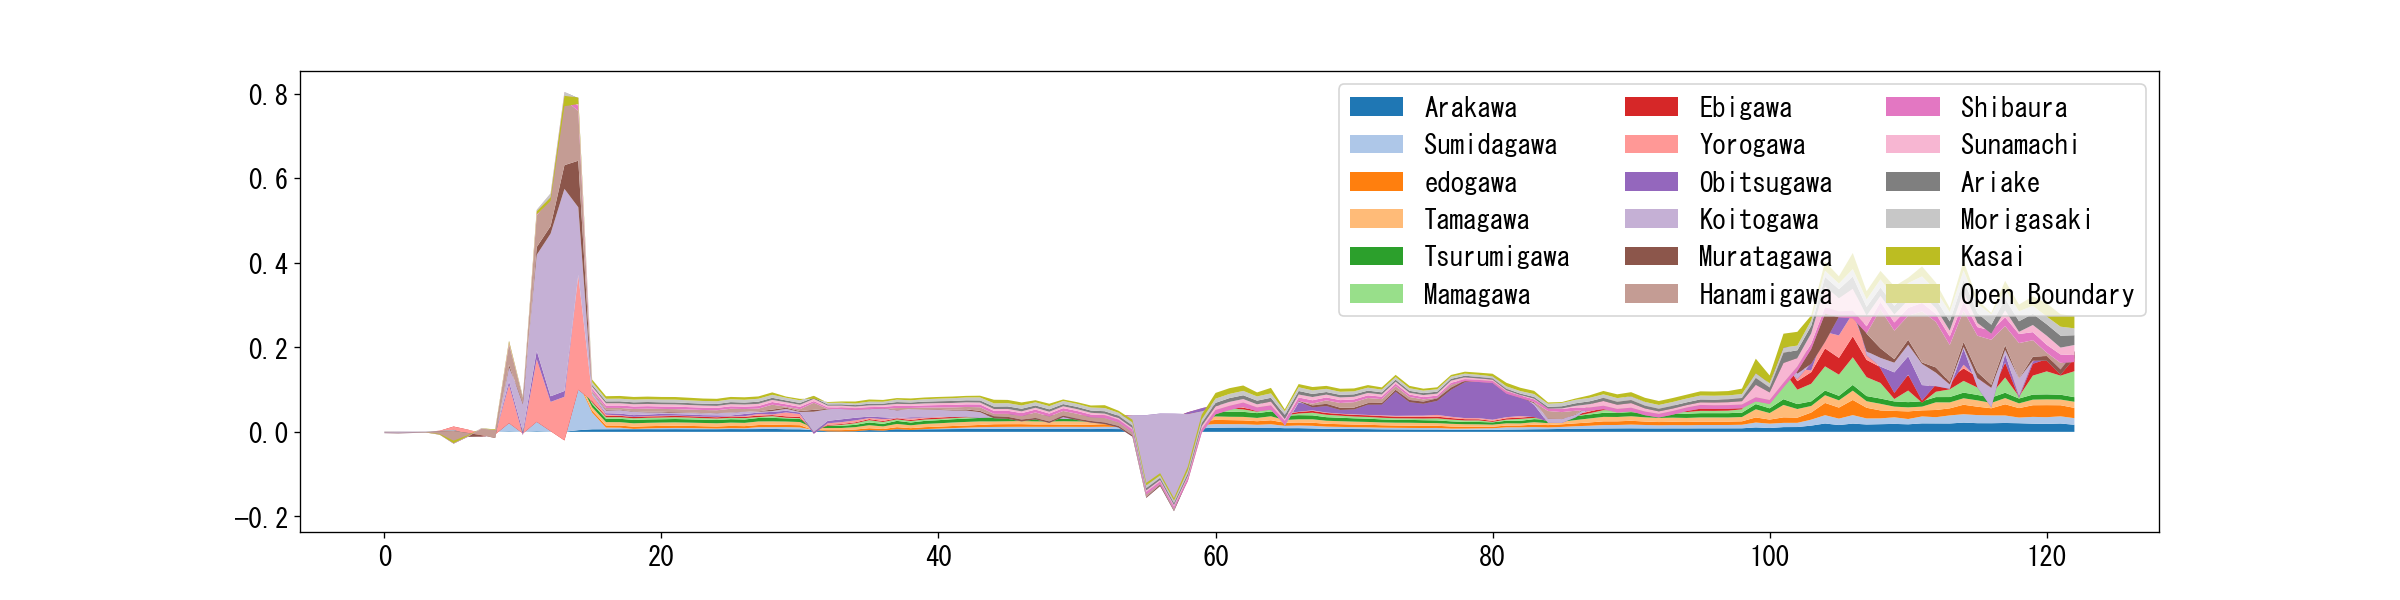

invalid value encountered in divide (C:\Users\ishid\AppData\Local\Temp\ipykernel_8388\3830003465.py:2)


In [181]:
fig,ax = plt.subplots(figsize=(20,5))
ax.stackplot(range(len(indices)),[verc[i,:] for i in range(len(river_list))],labels=river_list)
ax.legend(ncols=3)
plt.show()

C:\Users\ishid\AppData\Local\Temp\ipykernel_19944\2473011364.py:22: RuntimeWarning: invalid value encountered in double_scalars
  dye_spec[i] = (np.average(dye[t:t+ave,0,i]))/np.average(dye_base[t:t+ave,0,i]) #np.average(dye_base[t:t+ave,0,i])-


<IPython.core.display.Javascript object>


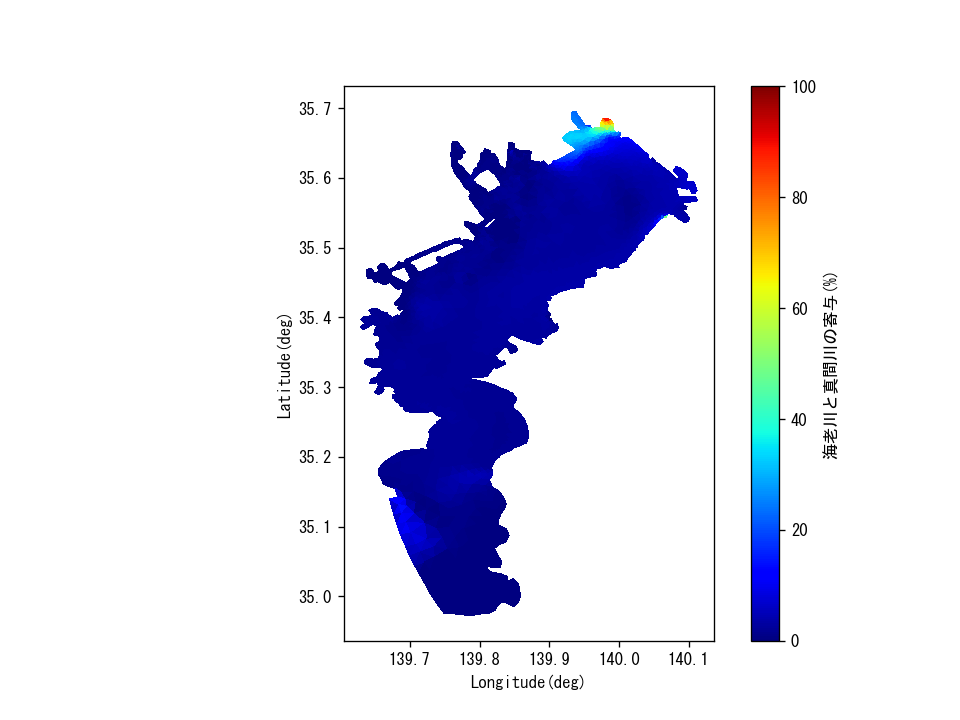

In [18]:
plt.rcParams['font.family'] = 'MS Gothic'
river_list = ["Open Boundary"]
DIN_INFLOW=[20]
path_init = "./exp31/exp7_0001.nc"
paths=[f"./exp31/exp{str(8)}_0001.nc" ]#for i in range()]
#ratio = [7.74,6.11,0.11,18.44,5.44]

nc = netCDF4.Dataset("./exp31/exp0_0001.nc",'r')
dye_base = nc.variables['DYE'][:,:,:]

dye,lon,lat,triangles,h,art1,siglay = read_map_and_dye(path_init)
dye = dye_base-dye
ntime,nsigma,nnode = dye.shape
for path in paths:   
    dye0,lon,lat,triangles,h,art1,siglay = read_map_and_dye(path)
    dye = dye + dye_base  - dye0
#print(dye)
dye_spec = np.zeros(nnode)
t = 55*24
ave = 24*7
for i in range(nnode):
    dye_spec[i] = (np.average(dye[t:t+ave,0,i]))/np.average(dye_base[t:t+ave,0,i]) #np.average(dye_base[t:t+ave,0,i])-
  #  if 1<dye_spec[i]:
  #      print(i)
       # dye_spec[i]=1
  #  if 0>dye_spec[i]:
  #      print(i)
       # dye_spec[i]=0
        
    
    
vmin = 0
vmax= 100#ratio

fig,axs = plt.subplots(figsize=(8,6))
axs.set_aspect('equal')
axs.set_ylabel('Latitude(deg)')
axs.set_xlabel('Longitude(deg)')

#initialize
pcolor = axs.tripcolor(lon,lat,dye_spec[:]*100,triangles=triangles,vmin=vmin,vmax=vmax,cmap='jet')
fig.colorbar(pcolor,label=f"海老川と真間川の寄与(%)")

fig.savefig('ratio_river.png',dpi=600,bbox_inches="tight")